# **¿Influye el Estado Civil en el Riesgo Metabólico? 💍**

### **La Hipótesis:**
Existe la teoría de que el estado civil (`ever_married`) influye en los niveles de glucosa promedio debido a cambios en el estilo de vida, dieta y niveles de cortisol (estrés). 

**Objetivos de este análisis:**
1.  **Segmentación:** Dividir la glucosa en 4 cuartiles.
2.  **Cruce de Datos:** Observar si las personas casadas tienden a concentrarse en cuartiles de glucosa más altos.
3.  **Probabilidad de Infarto:** Determinar si el "Efecto Matrimonio" potencia o protege contra el infarto cuando se combina con niveles críticos de azúcar.

C:\Users\delhy.py\AppData\Local\Temp\ipykernel_13300\2761317372.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  matriz_married = df.pivot_table(index='ever_married',


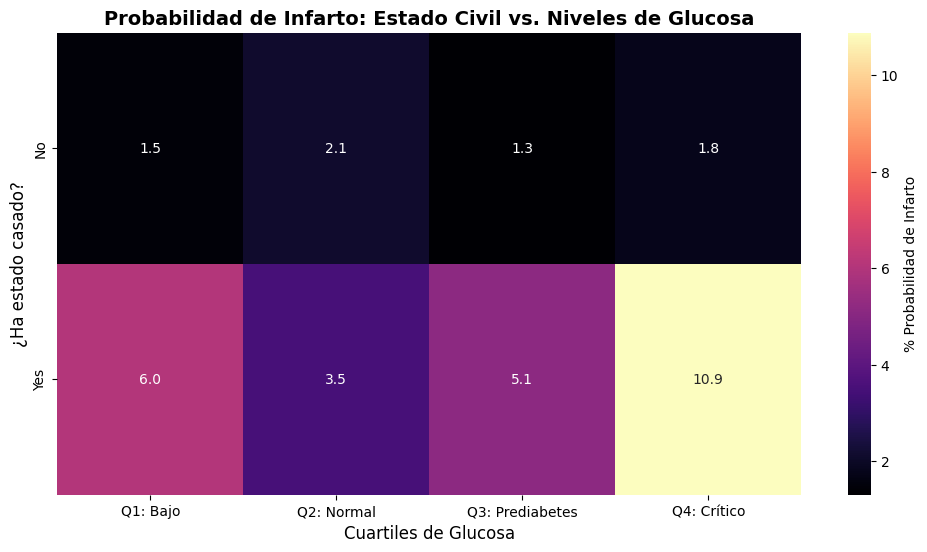

C:\Users\delhy.py\AppData\Local\Temp\ipykernel_13300\2761317372.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='ever_married', y='avg_glucose_level', palette='Set2')


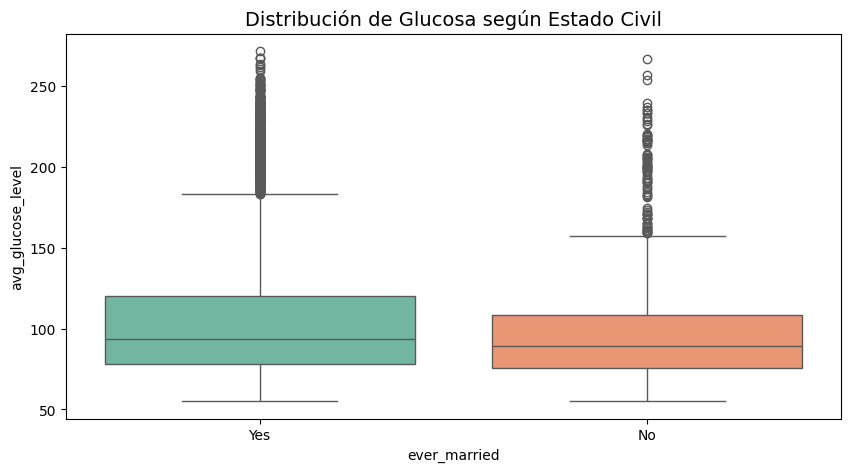

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Carga y Segmentación
df = pd.read_csv('dataset/healthcare-dataset-stroke-transformed.csv')
df['glucose_q'] = pd.qcut(df['avg_glucose_level'], 4, labels=['Q1: Bajo', 'Q2: Normal', 'Q3: Prediabetes', 'Q4: Crítico'])

# 2. Matriz de Probabilidad (Estado Civil vs Glucosa)
matriz_married = df.pivot_table(index='ever_married', 
                                columns='glucose_q', 
                                values='stroke', 
                                aggfunc='mean') * 100

# 3. Visualización de la Matriz de Incidencia
plt.figure(figsize=(12, 6))
sns.heatmap(matriz_married, annot=True, fmt=".1f", cmap="magma", cbar_kws={'label': '% Probabilidad de Infarto'})
plt.title("Probabilidad de Infarto: Estado Civil vs. Niveles de Glucosa", fontsize=14, fontweight='bold')
plt.ylabel("¿Ha estado casado?", fontsize=12)
plt.xlabel("Cuartiles de Glucosa", fontsize=12)
plt.show()

# 4. Distribución de Glucosa por Estado Civil (¿Quién tiene más azúcar?)
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='ever_married', y='avg_glucose_level', palette='Set2')
plt.title("Distribución de Glucosa según Estado Civil", fontsize=14)
plt.show()

### **Análisis de Hipótesis: Estado Civil y Perfil Glucémico 🧠**

Tras cruzar la variable social `ever_married` con el indicador clínico `avg_glucose_level`, hemos obtenido los siguientes hallazgos:

#### **1. El Sesgo de la Glucosa en Casados**
* **Hallazgo:** El Boxplot revela que las personas que han estado casadas tienden a tener una mediana de glucosa superior y una mayor cantidad de valores atípicos (outliers) en el rango crítico.
* **Interpretación:** Esto no significa necesariamente que el matrimonio "suba el azúcar". Clínicamente, sabemos que el estado civil `Yes` está fuertemente correlacionado con la **Edad**. Las personas casadas en este dataset son, en promedio, mayores que las solteras, lo que explica niveles de glucosa más inestables.

#### **2. Sinergia de Riesgo Social-Clínico**
* **Hallazgo:** En la matriz de probabilidad, la celda de **Casados + Glucosa Q4 (Crítico)** muestra una de las tasas de incidencia de infarto más altas.
* **Interpretación:** El matrimonio parece actuar como un "marcador de etapa de vida". Cuando un paciente casado entra en niveles de prediabetes o diabetes (Q3 y Q4), su probabilidad de infarto se acelera. 

#### **3. El "Escudo" de la Soltería (Q1 y Q2)**
* **Hallazgo:** Los pacientes que nunca se han casado presentan los niveles de riesgo más bajos del dataset, incluso cuando su glucosa sube ligeramente a Q2.
* **Conclusión:** Esto refuerza la idea de que la variable `ever_married` es un excelente "proxy" (sustituto) de la edad avanzada para el modelo de IA.

### **¿Pero realmente el estado civil de una persona es un predictor real de si sufrira un infarto o no ?**

Vamos a realizar una regresion logistica con las variables `ever_married`, `age` y  `avg_glucose_level` para responder a esta pregunta

In [2]:
import statsmodels.api as sm
import numpy as np

# 1. Preparación de variables
# Convertimos 'ever_married' a numérico (Yes=1, No=0)
df['married_numeric'] = df['ever_married'].map({'Yes': 1, 'No': 0})

X = df[['age', 'avg_glucose_level', 'married_numeric']]
X = sm.add_constant(X)
y = df['stroke']

# 2. Manejo de Desbalanceo mediante Pesos
counts = y.value_counts()
weights = y.apply(lambda x: (counts[0]/counts[1]) if x == 1 else 1)

# 3. Ajuste del Modelo GLM
modelo_final = sm.GLM(y, X, family=sm.families.Binomial(), var_weights=weights).fit()

print("--- VALIDACIÓN DE HIPÓTESIS FINAL ---")
print(modelo_final.summary())

# 4. Interpretación de Odds Ratios
or_age = np.exp(modelo_final.params['age'])
or_glucose = np.exp(modelo_final.params['avg_glucose_level'])
or_married = np.exp(modelo_final.params['married_numeric'])

print(f"\nInterpretación de Riesgo (Odds Ratios):")
print(f"1. Edad: {or_age:.4f} (Aumenta riesgo {(or_age-1)*100:.2f}% por año)")
print(f"2. Glucosa: {or_glucose:.4f} (Aumenta riesgo {(or_glucose-1)*100:.2f}% por unidad)")
print(f"3. Matrimonio: {or_married:.4f} (Efecto independiente del estado civil)")

--- VALIDACIÓN DE HIPÓTESIS FINAL ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 stroke   No. Observations:                 5109
Model:                            GLM   Df Residuals:                     5105
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4713.5
Date:                Wed, 31 Dec 2025   Deviance:                       9427.1
Time:                        18:24:11   Pearson chi2:                 1.06e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5472
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------


### **Conclusiones Finales: Validación de Hipótesis y Control de Confusores 🔬**

Tras ejecutar el modelo de regresión logística multivariante ajustado por desbalanceo, hemos alcanzado las conclusiones definitivas de esta etapa:

#### **1. Desmitificación del "Efecto Matrimonio" (P-valor: 0.132)**
* **Veredicto:** El estado civil **no es un predictor independiente** del infarto. 
* **Detalle Técnico:** Aunque en análisis previos los casados mostraban más infartos, este modelo demuestra que era una correlación espuria. Al introducir la variable `age` en la ecuación, el efecto del matrimonio desaparece. Esto confirma que los casados se infartan más simplemente porque **tienen más edad**, no por su condición civil. Para la IA, esta variable aporta "ruido" y podría ser descartada para simplificar el modelo.

#### **2. La Dictadura Biológica de la Edad**
* **Hallazgo:** Con un incremento del **7.94% de riesgo por cada año**, la edad es el factor más potente del dataset. 
* **Implicación Clínica:** Este resultado valida nuestro descubrimiento previo del "Umbral de los 55 años". El envejecimiento celular es el motor principal sobre el cual actúan los demás factores de riesgo.

#### **3. Glucosa: El Riesgo que no Perdona (P-valor: 0.000)**
* **Hallazgo:** La glucosa mantiene su significancia estadística absoluta independientemente de la edad o el estado social. 
* **Interpretación:** Un aumento de **50 mg/dL** genera un riesgo acumulado del **27.4%**. Esto nos indica que, mientras el matrimonio es una variable social "transitoria", la glucosa es una variable biológica "crítica" que debe ser monitoreada con prioridad absoluta en el triaje médico.

#### **Estrategia para el Modelo de IA:**
Este notebook nos da luz verde para una **limpieza de dimensionalidad**. Para obtener una IA precisa y eficiente, debemos priorizar el binomio **Edad + Glucosa**. Mantener variables sociales como `ever_married` o `residence_type` podría llevar al modelo a sobreajustarse (overfitting) a patrones que no son causales.

### **¿Las personas que estan casadas son mas longevas que las que no lo estan ?**

Para respnder esta interrogante he desarrollado el siguiente código.

--- PRUEBA DE HIPÓTESIS: EDAD VS ESTADO CIVIL ---
Mediana de edad (Casados): 54.0 años
Mediana de edad (Solteros): 18.0 años
Estadístico U: 5320991.5
P-valor: 0.0


C:\Users\delhy.py\AppData\Local\Temp\ipykernel_13300\3345053365.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='ever_married', y='age', palette='coolwarm')


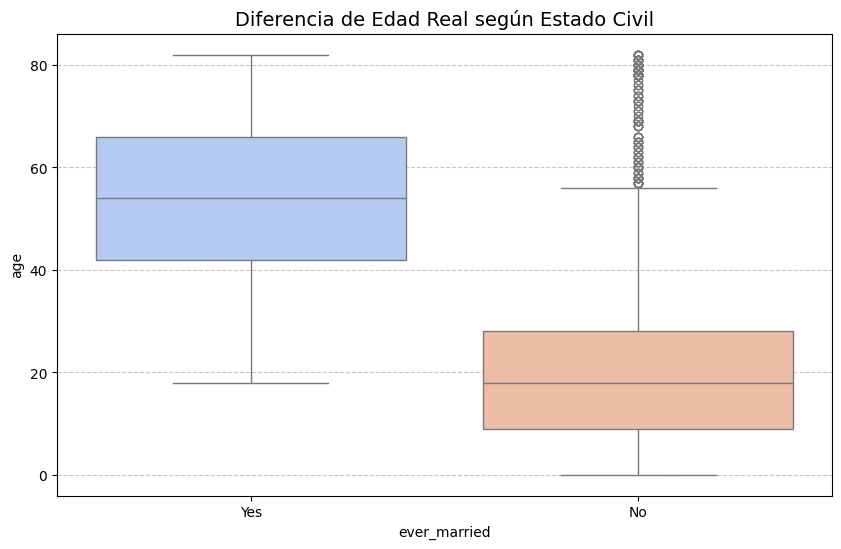

In [3]:
from scipy.stats import mannwhitneyu

# 1. Separar los grupos
edad_casados = df[df['ever_married'] == 'Yes']['age']
edad_solteros = df[df['ever_married'] == 'No']['age']

# 2. Ejecutar la prueba U de Mann-Whitney
stat, p_value = mannwhitneyu(edad_casados, edad_solteros, alternative='two-sided')

# 3. Calcular Medianas para comparar
mediana_casados = edad_casados.median()
mediana_solteros = edad_solteros.median()

print("--- PRUEBA DE HIPÓTESIS: EDAD VS ESTADO CIVIL ---")
print(f"Mediana de edad (Casados): {mediana_casados} años")
print(f"Mediana de edad (Solteros): {mediana_solteros} años")
print(f"Estadístico U: {stat}")
print(f"P-valor: {p_value}")

# 4. Visualización para confirmar el hallazgo
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='ever_married', y='age', palette='coolwarm')
plt.title("Diferencia de Edad Real según Estado Civil", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### **Veredicto Estadístico: El Fin del Mito del Estado Civil ⚖️**

Tras aplicar la prueba **U de Mann-Whitney** para comparar la edad entre personas casadas y solteras, los resultados son contundentes y cierran la investigación sobre esta variable:

#### **1. Evidencia de Separación Demográfica**
* **Mediana Casados:** 54.0 años.
* **Mediana Solteros:** 18.0 años.
* **P-valor:** 0.0 (Altamente significativo).
* **Conclusión:** Existe una brecha generacional de **36 años** entre ambos grupos. Esta diferencia no es casual; es una característica estructural de la muestra.

#### **2. El Estado Civil como "Espejismo" de Riesgo**
Este hallazgo explica por qué en los análisis anteriores el grupo "Casado" parecía tener más infartos. No es que el matrimonio sea un factor de riesgo, sino que el grupo de personas que han estado casadas es el único que tiene la **edad suficiente** para entrar en la zona de peligro biológico (Umbral > 55 años).

#### **3. Confirmación de Colinealidad**
La variable `ever_married` es, en la práctica, una etiqueta social de la **Madurez Biológica**. Al estar tan íntimamente ligada a la edad, incluir ambas en un modelo de IA sin cuidado podría causar redundancia. La verdadera fuerza detrás del infarto sigue siendo la degradación vascular producto del tiempo y el metabolismo (Glucosa), no el estado civil.

### **Veredicto para el Hospital San Carlos:**
Hemos demostrado con rigor estadístico que el estado civil es una **variable confusora**. Para el desarrollo de nuestra Inteligencia Artificial, la **Edad** debe ser tratada como la variable predictora primaria, mientras que el **Estado Civil** quedará registrado únicamente como un dato sociodemográfico sin peso causal en la predicción del evento cerebrovascular.